# Generative Adversarial Networks

В этом ноутбуке мы реализуем полносвязные и 'сверточные' генераторы и дискриминаторы

# Libraries

In [17]:
import os

import cv2
import torch
import torchvision
import numpy as np
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_kwargs = {}
if torch.cuda.is_available():
    train_kwargs['gpus'] = torch.cuda.device_count()
train_kwargs['max_epochs'] = 20
if torch.cuda.is_available():
    train_kwargs['max_epochs'] = 200
print(train_kwargs)

{'gpus': 1, 'max_epochs': 200}


# Data

Создадим опять же датасеты для MNIST

In [2]:
dataset_root = "../2nd Task/"
images_dir, labels_dir = "Mnist_X.npy", "Mnist_y.npy"
images, labels = np.load(os.path.join(dataset_root, images_dir)), np.load(os.path.join(dataset_root, labels_dir))
print(images.shape[0])

70000


In [18]:
BATCH_SIZE = 128
IMAGE_SIZE = (28, 28)
NOISE_DIM = 100
LOW_RES_SIZE = IMAGE_SIZE

In [4]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, input_size=None, target_size=None):
        self.input_size = input_size
        self.target_size = target_size
        self.all_images = X
        self.all_labels = y
    
    def __len__(self):
        return self.all_images.shape[0]
    
    def __getitem__(self, idx):
        
        image = self.all_images[idx]
        label = self.all_labels[idx]
        image_rgb = np.stack([image, image, image], axis=2)
        
        if self.input_size is not None:
            input_rgb = cv2.resize(image_rgb, self.input_size)
            input_rgb = (input_rgb / 255).astype(np.float32)
        if self.target_size is not None:
            image_rgb = cv2.resize(image_rgb, self.target_size)
        image_rgb = (image_rgb / 255).astype(np.float32)
        if self.input_size is not None:
            return torch.from_numpy(input_rgb * 2 - 1), torch.from_numpy(image_rgb * 2 - 1), label# tanh values in [-1, 1] -- для нелинейной функции приведем данные в новые значения
        else:
            return torch.from_numpy(image_rgb * 2 - 1), label  # tanh values in [-1, 1]

In [5]:
class MNISTGANDataModule(pl.LightningDataModule):
    def __init__(self, X, y, batch_size, shuffle=True):
        super().__init__()
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.X = X
        self.y = y
    
    def setup(self, stage=None):
        self.dataset = MNISTDataset(self.X, self.y, target_size=IMAGE_SIZE)
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=self.shuffle)

## Вспомогательные функции визуализации

In [3]:
def data2img(d: np.ndarray):
    return 0.5 * d + 0.5

def visualize_images(data, n_rows, n_cols):
    n_samples = n_rows * n_cols

    if len(data) != n_samples:
        sample_indices = np.random.choice(len(data), n_samples, replace=len(data) < n_samples)
    else:
        sample_indices = np.arange(len(data)).astype(int)

    plt.figure(figsize=(int(2.5 * n_cols), int(2.5 * n_rows)))
    for i, sample_index in enumerate(sample_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(data2img(data[sample_index]))
        plt.axis("off")
    plt.show()

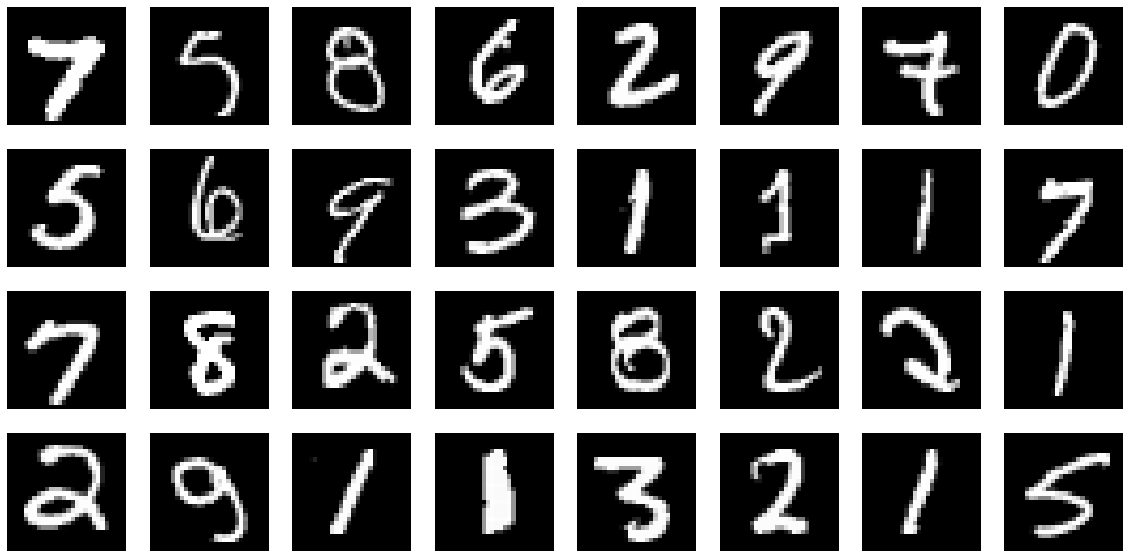

In [8]:
dm = MNISTGANDataModule(images, labels, batch_size=32)
dm.setup()
visualize_images(next(iter(dm.train_dataloader()))[0], 4, 8)

# Полносвязные генератор и дискриминатор

Создадим генератор, архитектура которого будет выглядеть так:
1. Из `100=NOISE_DIM` через линейный слой отобразим в **1024** элемента;
2. Применим `ReLU` с параметром `inplace=True` для некоторой экономии памяти;
3. Затем отобразим результат через линейный слой в **1024**;
4. Опять применим `ReLU` как в пункте 2;
5. Из **1024** отобразим линейным слоем в итоговое разрешение `28x28x3`;
6. Применим функцию активации `tanh`.

In [7]:
class FCGenerator(nn.Module):
    def __init__(self, noise_dim: int, img_shape: tuple):
        super().__init__()
        self.img_shape = img_shape
        self.noise_dim = noise_dim
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(noise_dim+10, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 28*28*3),
            nn.Tanh(),
            # TODO: add another layers
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), self.noise_dim)
        c = self.label_emb(labels)
        x = torch.cat([z, c], dim=-1)
        img = self.model(x)
        img = img.view(img.size(0), *self.img_shape)  # keep batch size
        return img

Небольшой тест.

In [10]:
fc_gen = FCGenerator(NOISE_DIM, IMAGE_SIZE + (3,))
img_generated = fc_gen(torch.randn(32, NOISE_DIM), torch.LongTensor(np.random.randint(0, 10, 32)))
assert img_generated.shape[1:] == IMAGE_SIZE + (3,)

Создадим дискриминатор, архитектура которого будет выглядеть так:

1. Представить изображение в виде одномерного вектора через `nn.Flatten()`;
2. Через линейное преобразование из итогового разрешения отоборазим в **256** элементов;
3. Применим `LeakyReLU(0.01)`;
4. Линейным слоем отобразим в **256** элементов;
5. Опять `LeakyReLU(0.01)`;
6. Линейным отображением в **1** элемент;
7. Наконец, нелинейное отображение через `Sigmoid`;

In [8]:
class FCDiscriminator(nn.Module):
    def __init__(self, img_shape: tuple):
        super().__init__()

        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(np.prod(np.array(img_shape))+10, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, 1),
            nn.Sigmoid(),
            # TODO: add all layers
        )
    
    def forward(self, img, labels):
        x = img.view(img.size(0), -1)
        c = self.label_emb(labels)
        img_flat = torch.cat([x, c], dim=-1)

        return self.model(img_flat)

In [12]:
fc_dis = FCDiscriminator(IMAGE_SIZE + (3,))
prob_dis = fc_dis(img_generated, torch.LongTensor(np.random.randint(0, 10, 32)))
assert prob_dis.shape[1:] == (1,)

# Сверточный генератор и дискриминатор

> Здесь и далее `ReLU` с параметром `inplace=True`

Создадим генератор с следующей архитектурой архитектурой:
1. Сначала через линейный слой отобразим в **128\*7\*7**;
2. Затем полученный вектор представим модулем, определенным в следующей ячейке в **128, 7, 7**;
3. К результату применим `ReLU`;
4. Затем используем `UpSample` слой с увеличением разрешения в 2 раза;
5. Затем применим свертку из исходного разрешения **128, 7, 7** в **128** слоев с размером ядра **3**, добавляя нули к исходному изображению так, чтобы в итоге получилось изображение размеров, как в результате пункта 4 -- `padding='same'`ж
6. Используем нормализацию с параметром момента `momentum=0.8`;
7. Опять применение `ReLU`;
8. Повторим п.4-7, но свертки п.5 уже в **64** слоя;
9. Используем свертку для преобразования в **3** канала из 64-х;
10. Используем слой активации `nn.Tanh()`;

In [19]:
class Reshape(nn.Module):
    def __init__(self, new_shape: tuple):
        super().__init__()
        self.new_shape = new_shape
        
    def forward(self, z):
        return z.view(z.size(0), *self.new_shape)

In [10]:
class DCGenerator(nn.Module):
    def __init__(self, noise_dim: int, img_shape: tuple):
        super().__init__()
        self.img_shape = img_shape

        self.label_emb = nn.Embedding(10, 10)
        
        self.x_layer = nn.Sequential(
            nn.Linear(noise_dim, 128*7*7),
            Reshape((128, 7, 7)),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2)
        )

        self.y_layer = nn.Sequential(
            nn.Linear(10, 128*7*7),
            Reshape((128, 7, 7)),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2)
        )

        self.model = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding='same'),
            nn.Tanh()  
            # TODO: add all layers
        )
    
    def forward(self, z, labels):
        labels = self.label_emb(labels)
        img = self.x_layer(z)
        label = self.y_layer(labels)
        res_img = torch.cat([img, label], dim=1)
        res_img = self.model(res_img)
        res_img = res_img.permute(0, 2, 3, 1)  # make channel axis last
        return res_img

In [15]:
dc_gen = DCGenerator(NOISE_DIM, IMAGE_SIZE + (3,))
fake_imgs = dc_gen(torch.randn(10, NOISE_DIM), torch.randint(0, 10, (10,)))
assert fake_imgs.shape[1:] == IMAGE_SIZE + (3,)

Создаем сверточный дискриминатор с архитектурой:
1. Свертка из исходного разрешения в **32** с параметрами `kernel_size=3, stride=2, padding=1` - последнее есть аналог `padding='same'`, но при заданном шаге `stride` нужно устанавливать только числовой показатель
2. Leaky ReLU(0.2)
3. Dropout(0.25)
4. Conv2D: 3x3, filters=64, strides=2, padding="same"
5. Zero Padding 2D: ((0, 1), (0, 1))
6. Batch Normalization 2D with momentum(0.8)
7. Leaky ReLU(0.2)
8. Dropout(0.25)
9. Conv2D: 3x3, filters=128, strides=2, padding="same"
10. Batch Normalization 2D with momentum(0.8)
11. Leaky ReLU(0.2)
12. Dropout(0.25)
13. Conv2D: 3x3, filters=256, strides=2, padding="same"
14. Batch Normalization 2D with momentum(0.8)
15. Leaky ReLU(0.2)
16. Dropout(0.25)
17. Flatten
18. Fully connected layer with output size 1
19. Sigmoid

In [11]:
class DCDiscriminator(nn.Module):
    def __init__(self, img_shape: tuple):
        super().__init__()

        self.x_layer = nn.Sequential(
            nn.Conv2d(img_shape[2], 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
        )

        self.y_layer = nn.Sequential(
            nn.Conv2d(10, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
        )
        self.model = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(256*2*2, 1),
            nn.Sigmoid(),
            # TODO: add all layers
        )
    
    def forward(self, img, labels):
        label_fill = torch.zeros([labels.shape[0], 10, 28, 28]).type_as(img)
        for idx, element in enumerate(labels):
            label_fill[idx, element, :, :] = 1

        img = img.permute(0, 3, 1, 2)  # channels first

        img = self.x_layer(img)
        labels = self.y_layer(label_fill)
        img_chan = torch.cat([img, labels], dim=1)

        return self.model(img_chan)

In [17]:
dc_dis = DCDiscriminator(img_shape=IMAGE_SIZE + (3,))
fake_proba = dc_dis(fake_imgs, torch.randint(0, 10, (10,)))
assert fake_proba.shape[1:] == (1,)

# Net training

## FCGan

In [12]:
class FCGAN(pl.LightningModule):
    def __init__(self, width, height, channels, noise_dim=100, lr=0.0002, b1=0.5, b2=0.999):
        super().__init__()
        self.save_hyperparameters()  # make <arg> available as self.hparams.<arg>
        
        img_shape = (width, height, channels)
        self.generator = FCGenerator(noise_dim=self.hparams.noise_dim, img_shape=img_shape)
        self.discriminator = FCDiscriminator(img_shape=img_shape)
        
        self.validation_z = torch.randn(8, noise_dim)
        self.validation_y = torch.randint(0, 10, (8,))
    
    def forward(self, z, y):
        return self.generator(z, y)
    
    def gan_loss(self, y_hat, y):
        loss = nn.BCELoss()
        return loss(y_hat, y)# TODO: implement GAN loss (hint: binary cross entropy)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, labels = batch
        labels = labels.long()
            
        z = torch.randn(imgs.size(0), self.hparams.noise_dim)
        z = z.type_as(imgs)  # move to same device as imgs

        y = torch.randint(0, 10, (imgs.size(0),))
        y = y.type_as(labels)

        if optimizer_idx == 0:  # generator
            self.generated_imgs = self(z, y)
            
            valid = torch.ones(imgs.size(0), 1)  # all fake, but we want to be real
            valid = valid.type_as(imgs)
            
            g_loss = self.gan_loss(self.discriminator(self(z, y), y), valid)
            self.log('g_loss', g_loss, prog_bar=True)
            return {'loss': g_loss}
        
        if optimizer_idx == 1:  # discriminator
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)
            
            real_loss = self.gan_loss(self.discriminator(imgs, labels), valid)# TODO: loss for `discriminator(imgs)` and `valid`
            
            fake = torch.zeros(imgs.size(0), 1)# TODO: zero vector for fake_loss computation
            fake = fake.type_as(imgs)

            fake_loss = self.gan_loss(self.discriminator(self(z, y).detach(), y), fake)
            
            d_loss = (real_loss + fake_loss) / 2
            self.log('d_loss', d_loss, prog_bar=True)
            return {'loss': d_loss}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        # send results for validation_z to TensorBoard
        z = self.validation_z.type_as(self.generator.model[0].weight)
        y = self.validation_y.to(self.device)
        
        sample_imgs = self(z, y).permute(0, 3, 1, 2)  # channels before pixels
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

In [19]:
dm = MNISTGANDataModule(images, labels, batch_size=BATCH_SIZE)
cfcmodel = FCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
trainer = pl.Trainer(**train_kwargs)
trainer.fit(cfcmodel, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rw/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:307: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | generator     | FCGenerator     | 3.6 M 
1 | discriminator | FCDiscriminator | 671 K 
--------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.981    Total estimated model params size (MB)
/home/rw/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarnin

Training: 0it [00:00, ?it/s]

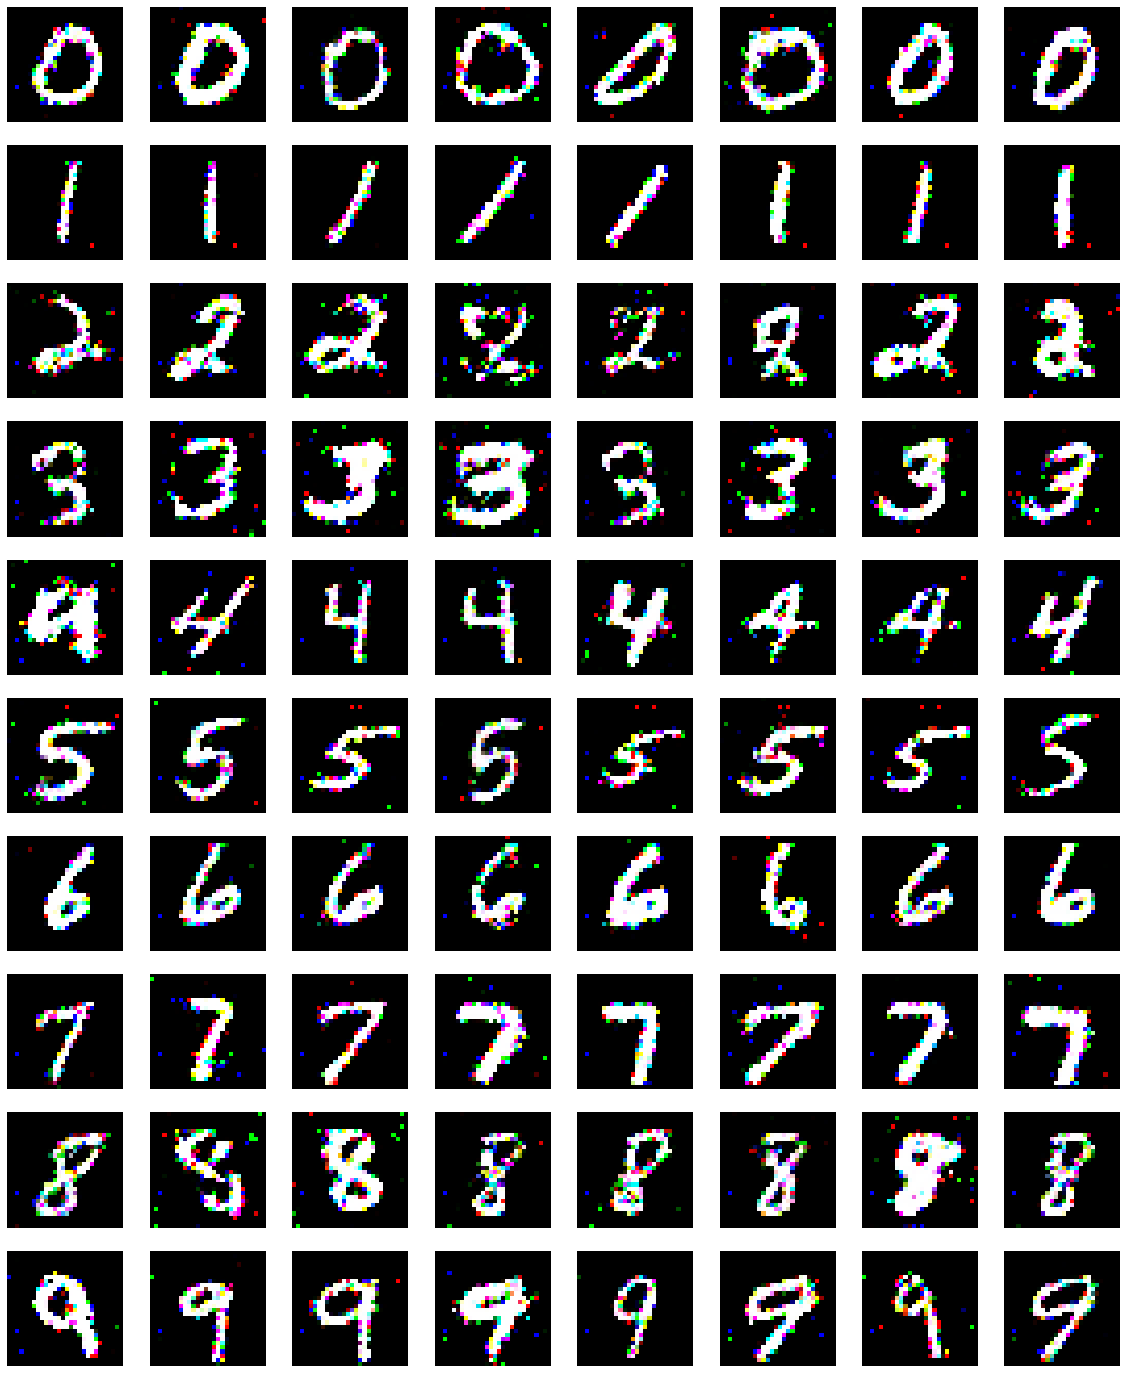

In [27]:
cfcmodel.training=False
cfcmodel.cpu()
data = []
for i in range(10):
    for k in range(8):
        data.append(cfcmodel(torch.randn(1, NOISE_DIM), torch.tensor([i], dtype=torch.int64)).detach()[0])
visualize_images(data, 10, 8)

In [13]:
pretrainedCFCGAN = torch.load("cfcgan_200")
torch.save(pretrainedCFCGAN.state_dict(), "modelsWeights/cfcgan200")

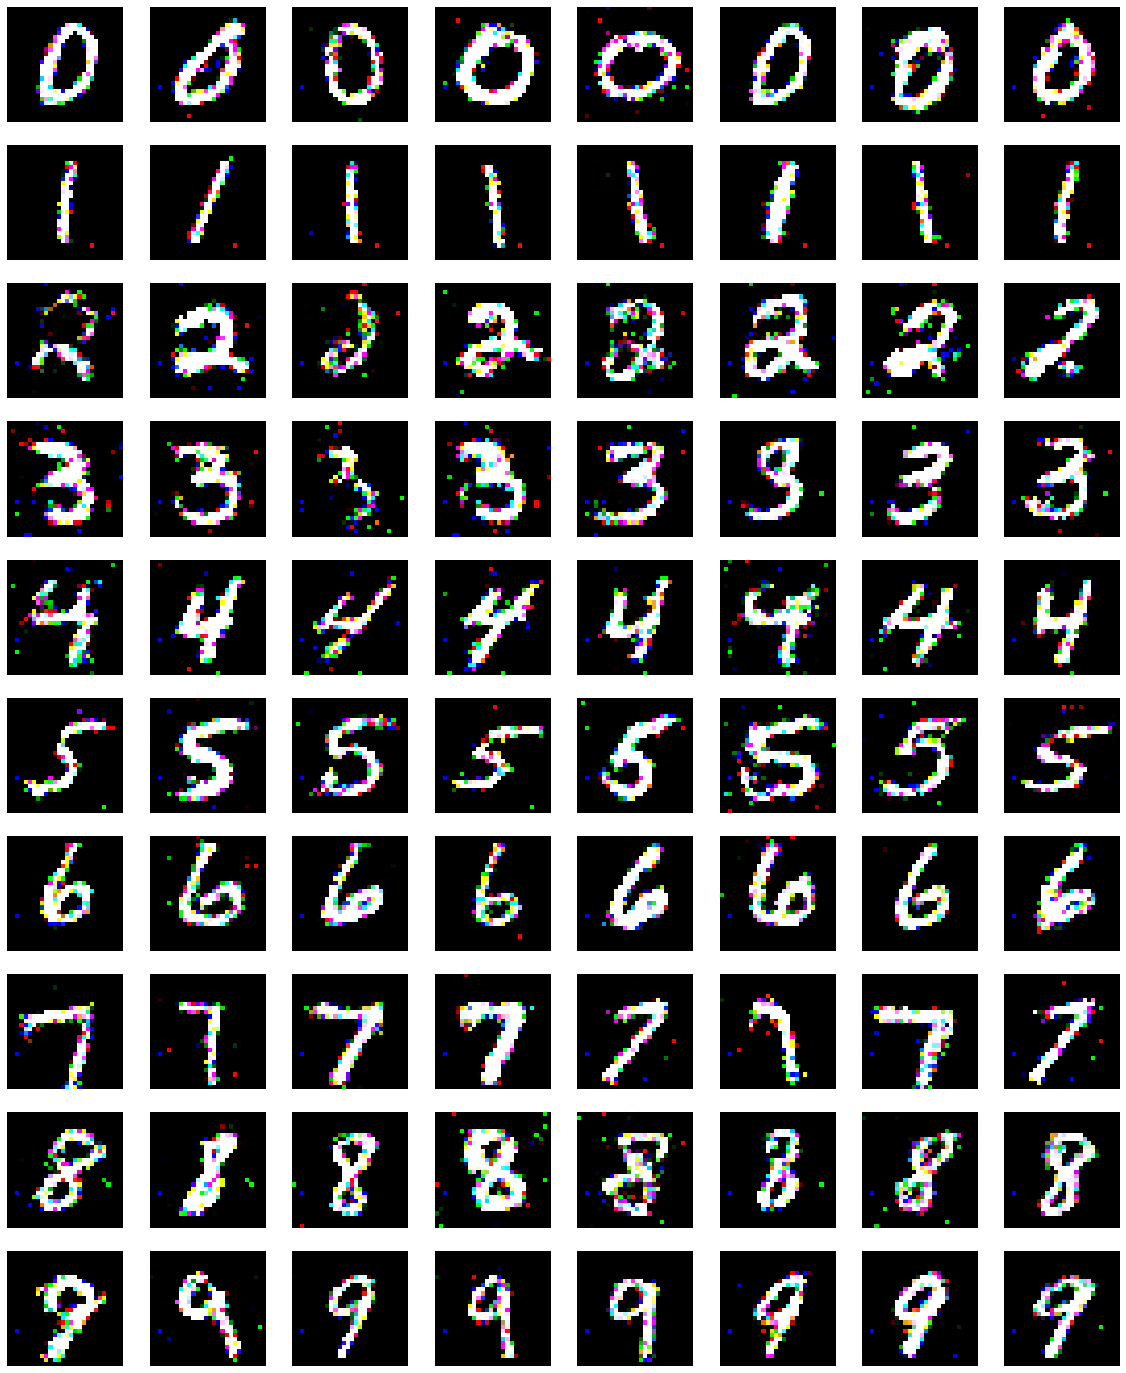

In [13]:
pretrainedCFCGAN = FCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
pretrainedCFCGAN.load_state_dict(torch.load("modelsWeights/cfcgan200"))
pretrainedCFCGAN.eval()

data = []
for i in range(10):
    for k in range(8):
        data.append(pretrainedCFCGAN(torch.randn(1, NOISE_DIM), torch.tensor([i], dtype=torch.int64)).detach()[0])
visualize_images(data, 10, 8)

## DCGan

In [14]:
class DCGAN(pl.LightningModule):
    def __init__(self, width, height, channels, noise_dim=100, lr=0.0002, b1=0.5, b2=0.999):
        super().__init__()
        self.save_hyperparameters()  # make <arg> available as self.hparams.<arg>
        
        img_shape = (width, height, channels)
        self.generator = DCGenerator(noise_dim=self.hparams.noise_dim, img_shape=img_shape)
        self.discriminator = DCDiscriminator(img_shape=img_shape)
        
        self.validation_z = torch.randn(8, noise_dim)
        self.validation_y = torch.randint(0, 10, (8,))
    
    def forward(self, z, y):
        return self.generator(z, y)
    
    def gan_loss(self, y_hat, y):
        loss = nn.BCELoss()
        return loss(y_hat, y)# TODO: implement GAN loss (hint: binary cross entropy)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, labels = batch
        labels = labels.long()
        
        z = torch.randn(imgs.size(0), self.hparams.noise_dim)
        z = z.type_as(imgs)  # move to same device as imgs

        y = torch.randint(0, 10, (imgs.size(0),))
        y = y.type_as(labels)
        
        if optimizer_idx == 0:  # generator
            self.generated_imgs = self(z, y)
            
            valid = torch.ones(imgs.size(0), 1)  # all fake, but we want to be real
            valid = valid.type_as(imgs)
            
            g_loss = self.gan_loss(self.discriminator(self(z, y), y), valid)

            self.log('g_loss', g_loss, prog_bar=True)
            return {'loss': g_loss}
        
        if optimizer_idx == 1:  # discriminator
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)
            
            real_loss = self.gan_loss(self.discriminator(imgs, labels), valid)# TODO: loss for `discriminator(imgs)` and `valid`
            
            fake = torch.zeros(imgs.size(0), 1)# TODO: zero vector for fake_loss computation
            fake = fake.type_as(imgs)

            fake_loss = self.gan_loss(self.discriminator(self(z, y).detach(), y), fake)
            
            d_loss = (real_loss + fake_loss) / 2
            self.log('d_loss', d_loss, prog_bar=True)
            return {'loss': d_loss}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        # send results for validation_z to TensorBoard

        z = self.validation_z.type_as(self.generator.model[0].weight)
        y = self.validation_y.to(self.device)
        sample_imgs = self(z, y).permute(0, 3, 1, 2)  # channels before pixels
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

In [23]:
dm = MNISTGANDataModule(images, labels, batch_size=BATCH_SIZE)
cdcmodel = DCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
trainer = pl.Trainer(**train_kwargs)
trainer.fit(cdcmodel, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type            | Params
--------------------------------------------------
0 | generator     | DCGenerator     | 1.1 M 
1 | discriminator | DCDiscriminator | 411 K 
--------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.941     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

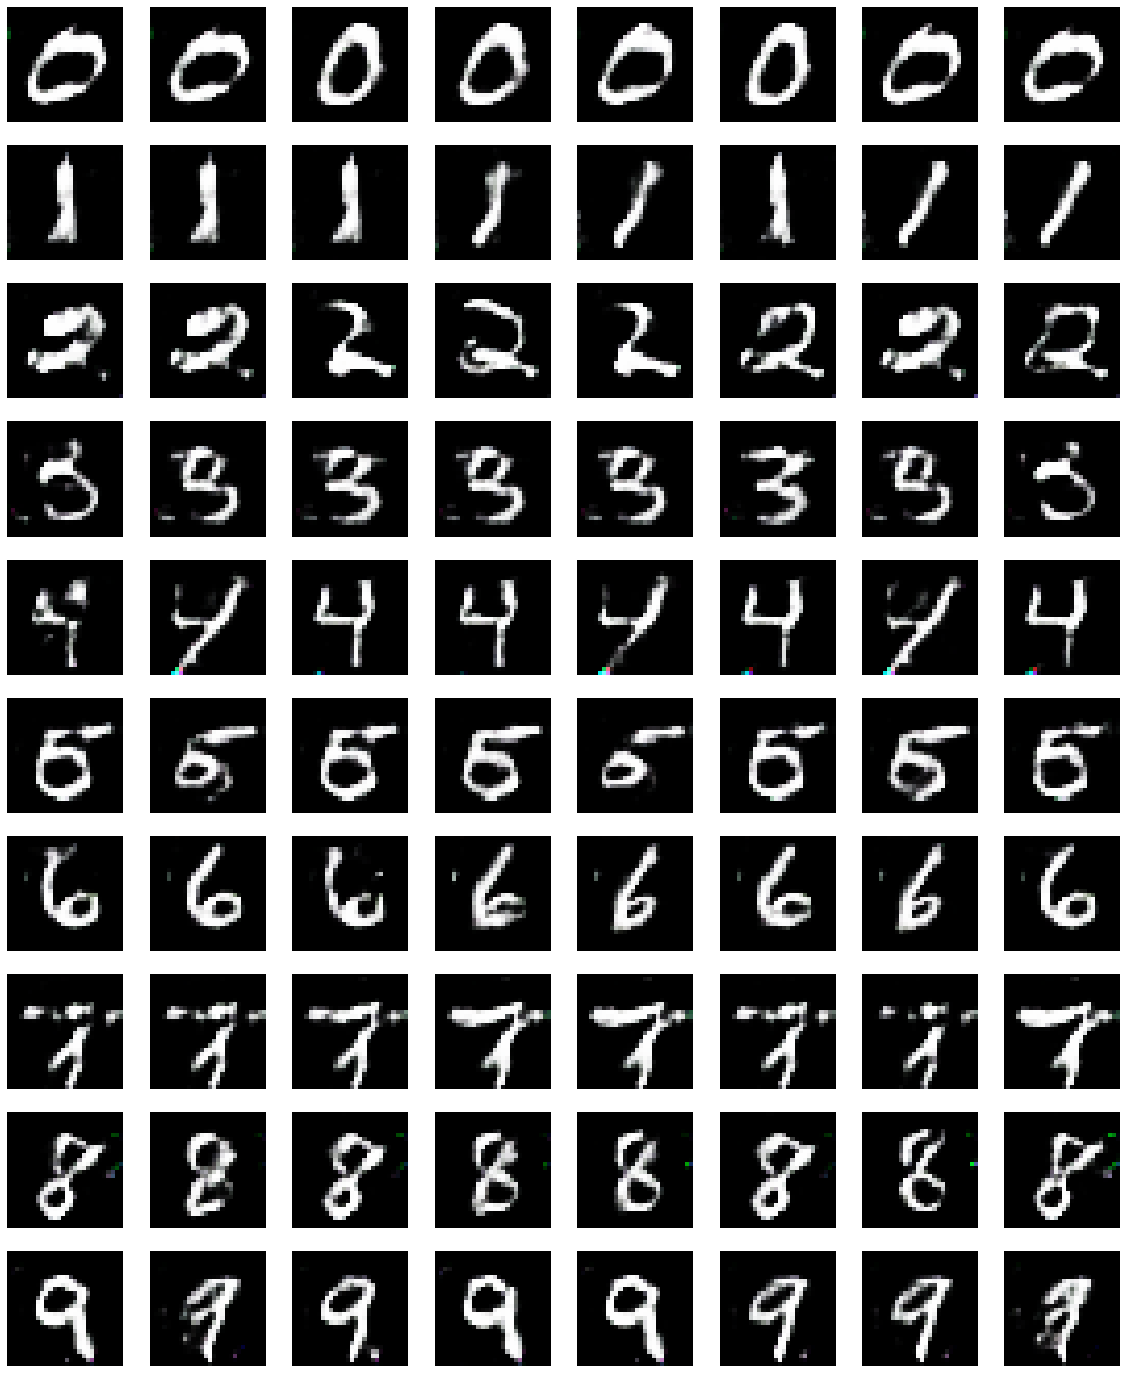

In [26]:
cdcmodel.cpu()
data = []
for i in range(10):
    for k in range(8):
        data.append(cdcmodel(torch.randn(1, NOISE_DIM), torch.tensor([i], dtype=torch.int64)).detach()[0])
visualize_images(data, 10, 8)

In [16]:
pretrainedCDCGAN = torch.load("cdcgan_200")
torch.save(pretrainedCDCGAN.state_dict(), "modelsWeights/cdcgan200")

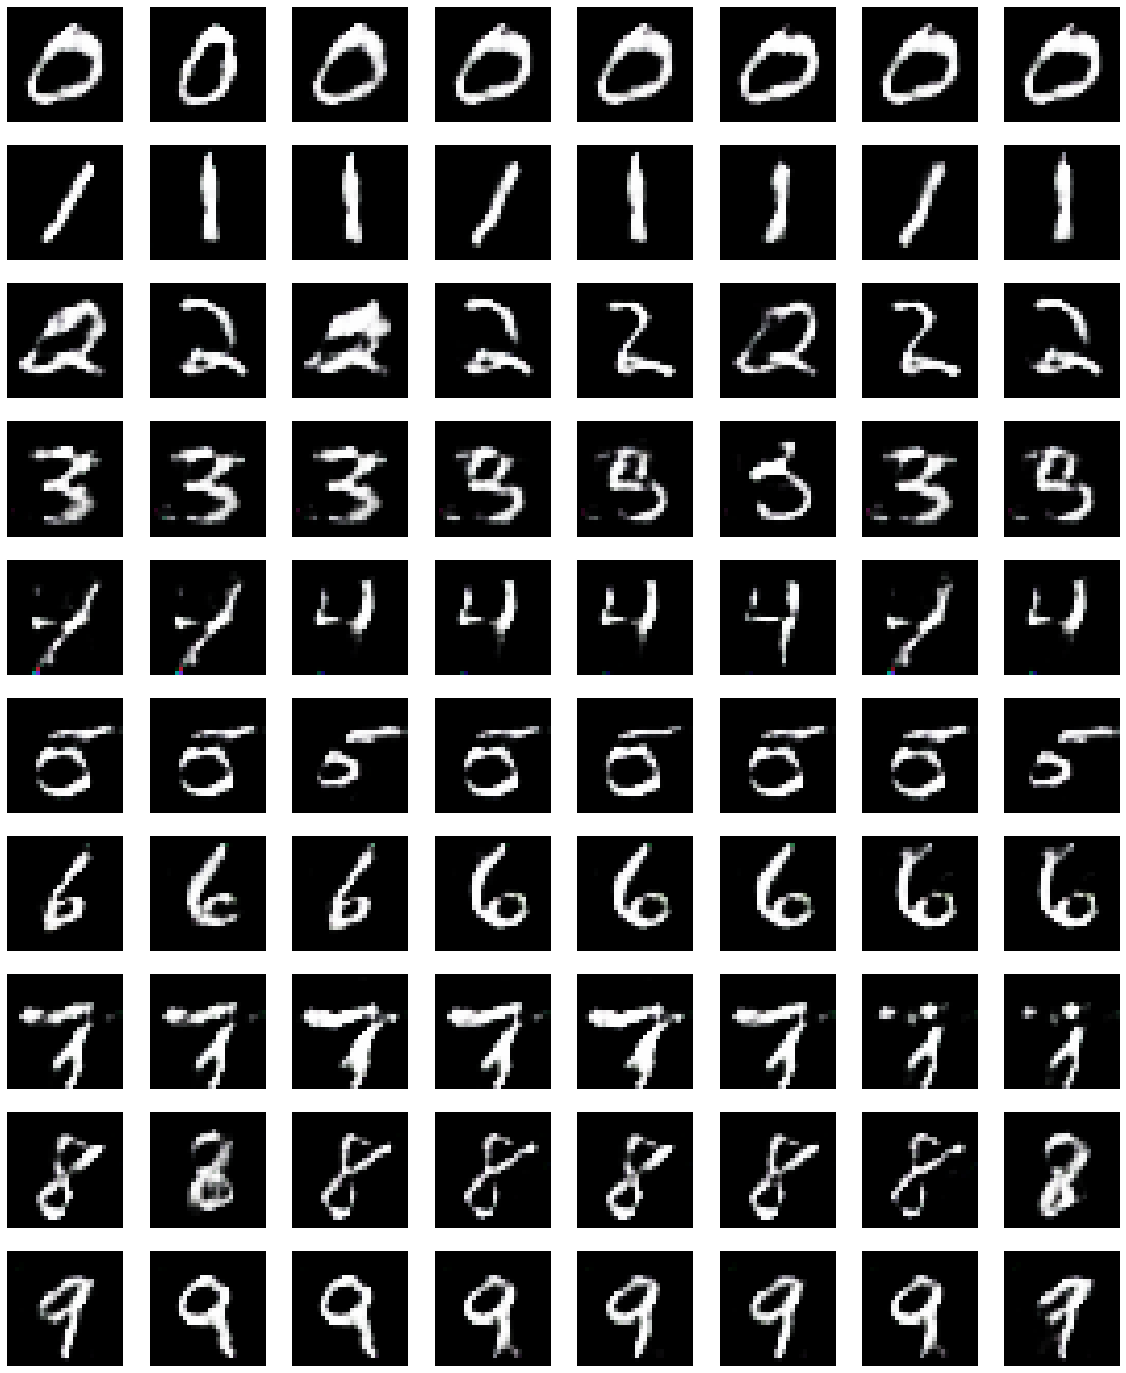

In [15]:
pretrainedCDCGAN = DCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
pretrainedCDCGAN.load_state_dict(torch.load("modelsWeights/cdcgan200"))
pretrainedCDCGAN.eval()

data = []
for i in range(10):
    for k in range(8):
        data.append(pretrainedCDCGAN(torch.randn(1, NOISE_DIM), torch.tensor([i], dtype=torch.int64)).detach()[0])
visualize_images(data, 10, 8)

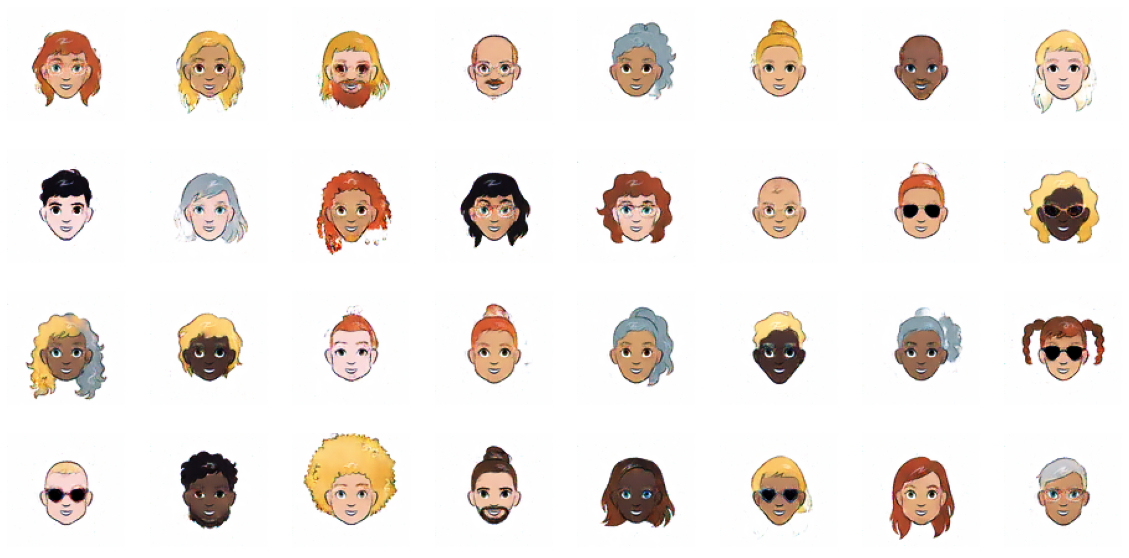

In [31]:
import avatar as a
m_gan1 = a.AVATARGAN(96, 96, 3)
m_gan1.load_state_dict(torch.load("../4th Task/modelsWeights/ava200"))
m_gan1.eval()

visualize_images(m_gan1(torch.randn(32, NOISE_DIM)).detach(), 4, 8)